<a href="https://colab.research.google.com/github/sunilvengalil/BloodVesselSegment/blob/master/fundal_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Google colab

1. Go to google colab

   https://colab.research.google.com/notebooks/intro.ipynb

2. Create a new notebook using menu File -> New Notebook
 
3. Rename the notebook to fundal_image_segmentation.ipynb

4. Change the runtime enviroment to GPU



> Go to Menu Runtime -> Change Runtime type. From the dropdown select 'GPU'. Click on 'Save' button


# Import all packages used

In [1]:
from google.colab import drive
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import h5py
from six.moves import configparser
import random

import torch
import torch.nn.functional as F  # Various activation functions
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

%matplotlib inline


# 1. Mount google drive
Mount `MyDrive` in your google drive as  `/content/gdrive`

While running the following cell, you will be prompted to click on a link in order to generate access key to access your google drive. 

Copy paste the acess key into the input field and press Enter

In [2]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Check the current working directory and list the files/folders in current directory. Make sure `gdive` is mounted

In [3]:
!pwd
!ls

/content
checkpoint  gdrive  logs  sample_data


# 2. Get the code from github

Create a new directory `fundal_image` and download code and data from github `https://github.com/juntang-zhuang/LadderNet.git`

In [4]:
%cd /content/gdrive/MyDrive
# !mkdir fundal_image
%cd fundal_image
# !git clone https://github.com/juntang-zhuang/LadderNet.git

/content/gdrive/MyDrive
/content/gdrive/MyDrive/fundal_image


# 3. Display sample training image from DRIVE dataset

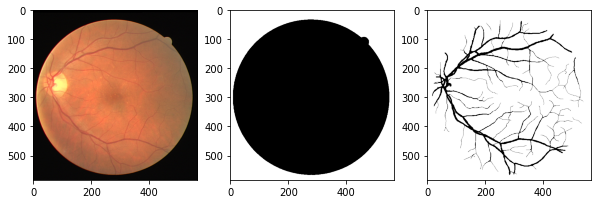

In [5]:
train_img = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/images/21_training.tif")
train_mask = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/mask/21_training_mask.gif")
train_gt = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/1st_manual/21_manual1.gif")

fig = plt.figure(figsize= (10,20))
ax = fig.add_subplot(1, 3, 1 )
ax.imshow(train_img)
ax2 = fig.add_subplot(1, 3, 2 )
ax2.imshow(train_mask, cmap="Greys")
ax3 = fig.add_subplot(1, 3, 3 )
ax3.imshow(train_gt, cmap="Greys")

plt.show()


# 4. Edit the configuration file

Open the file `gdrive/Mydrive/fundal_image/LadderNet/` configuration.txt and modify the values of following configuration parameters to below mentioned values

```
root_path = "/content/gdrive/MyDrive/fundal_image/LadderNet/"
path_local =  DRIVE_datasets_training_testing/
N_subimgs=1900
N_epochs = 50
Batch_size=32
average_mode = False
```






# Helper Functions

In [6]:
def load_hdf5(infile):
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]

def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)

#convert RGB image in black and white
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

# group a set of images row per columns
def group_images(data, per_row):
    assert data.shape[0]%per_row==0
    assert (data.shape[1]==1 or data.shape[1]==3)
    data = np.transpose(data,(0, 2, 3, 1))  #corect format for imshow
    all_stripe = []
    for i in range(int(data.shape[0]/per_row)):
        stripe = data[i * per_row]
        for k in range(i * per_row + 1, i * per_row+per_row):
            stripe = np.concatenate((stripe, data[k]), axis=1)
        all_stripe.append(stripe)
    totimg = all_stripe[0]
    for i in range(1, len(all_stripe)):
        totimg = np.concatenate((totimg, all_stripe[i]), axis=0)
    return totimg


#visualize image (as PIL image, NOT as matplotlib!)
def visualize(data,filename):
    assert (len(data.shape)==3) #height*width*channels
    img = None
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    img.save(filename + '.png')
    return img


def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,2)
    assert (pred.shape[2]==2 )  #check the classes are 2
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1]
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Load configuration settings

In [7]:
#=========  Load settings from Config file
root_path = "/content/gdrive/MyDrive/fundal_image/LadderNet/"
config = configparser.RawConfigParser()
config.read(root_path + '/configuration.txt')
dataset_path = root_path + "DRIVE_datasets_training_testing/"

#Experiment name
name_experiment = config.get('experiment name', 'name')
#training settings
N_epochs = int(config.get('training settings', 'N_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))


# 5. Prepare training and test data 

Read the test and train data from DRIVE dataset and save as hd5 file format

In [8]:
def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)

def get_datasets(imgs_dir,groundTruth_dir,borderMasks_dir,train_test="null"):
    imgs = np.empty((Nimgs, height, width, channels))
    groundTruth = np.empty((Nimgs, height, width))
    border_masks = np.empty((Nimgs, height, width))
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #original
            print("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            imgs[i] = np.asarray(img)
            #corresponding ground truth
            groundTruth_name = files[i][0:2] + "_manual1.gif"
            print("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            groundTruth[i] = np.asarray(g_truth)
            #corresponding border masks
            border_masks_name = ""
            if train_test=="train":
                border_masks_name = files[i][0:2] + "_training_mask.gif"
            elif train_test=="test":
                border_masks_name = files[i][0:2] + "_test_mask.gif"
            else:
                print("specify if train or test!!")
                exit()
            print("border masks name: " + border_masks_name)
            b_mask = Image.open(borderMasks_dir + border_masks_name)
            border_masks[i] = np.asarray(b_mask)

    print("imgs max: " +str(np.max(imgs)))
    print("imgs min: " +str(np.min(imgs)))
    assert(np.max(groundTruth)==255 and np.max(border_masks)==255)
    assert(np.min(groundTruth)==0 and np.min(border_masks)==0)
    print("ground truth and border masks are correctly withih pixel value range 0-255 (black-white)")
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,channels,height,width))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,height,width))
    border_masks = np.reshape(border_masks,(Nimgs,1,height,width))
    assert(groundTruth.shape == (Nimgs,1,height,width))
    assert(border_masks.shape == (Nimgs,1,height,width))
    return imgs, groundTruth, border_masks

In [9]:
#------------Path of the images --------------------------------------------------------------
#train
original_imgs_train = root_path + "/DRIVE/training/images/"
groundTruth_imgs_train = root_path + "/DRIVE/training/1st_manual/"
borderMasks_imgs_train = root_path + "/DRIVE/training/mask/"

#test
original_imgs_test = root_path + "/DRIVE/test/images/"
groundTruth_imgs_test = root_path + "/DRIVE/test/1st_manual/"
borderMasks_imgs_test = root_path + "/DRIVE/test/mask/"
#---------------------------------------------------------------------------------------------

Nimgs = 20
channels = 3
height = 584
width = 565

if not os.path.isdir(dataset_path):
    os.mkdir(dataset_path)
# getting the training datasets
imgs_train, groundTruth_train, border_masks_train = get_datasets(original_imgs_train,
                                                                 groundTruth_imgs_train,
                                                                 borderMasks_imgs_train,
                                                                 "train")
print("saving train datasets")
write_hdf5(imgs_train, dataset_path + "DRIVE_dataset_imgs_train.hdf5")
write_hdf5(groundTruth_train, dataset_path + "DRIVE_dataset_groundTruth_train.hdf5")
write_hdf5(border_masks_train,dataset_path + "DRIVE_dataset_borderMasks_train.hdf5")

# #getting the testing datasets
imgs_test, groundTruth_test, border_masks_test = get_datasets(original_imgs_test,groundTruth_imgs_test,borderMasks_imgs_test,"test")
print("saving test datasets")
write_hdf5(imgs_test,dataset_path + "DRIVE_dataset_imgs_test.hdf5")
write_hdf5(groundTruth_test, dataset_path + "DRIVE_dataset_groundTruth_test.hdf5")
write_hdf5(border_masks_test,dataset_path + "DRIVE_dataset_borderMasks_test.hdf5")


original image: 21_training.tif
ground truth name: 21_manual1.gif
border masks name: 21_training_mask.gif
original image: 22_training.tif
ground truth name: 22_manual1.gif
border masks name: 22_training_mask.gif
original image: 23_training.tif
ground truth name: 23_manual1.gif
border masks name: 23_training_mask.gif
original image: 24_training.tif
ground truth name: 24_manual1.gif
border masks name: 24_training_mask.gif
original image: 25_training.tif
ground truth name: 25_manual1.gif
border masks name: 25_training_mask.gif
original image: 26_training.tif
ground truth name: 26_manual1.gif
border masks name: 26_training_mask.gif
original image: 27_training.tif
ground truth name: 27_manual1.gif
border masks name: 27_training_mask.gif
original image: 28_training.tif
ground truth name: 28_manual1.gif
border masks name: 28_training_mask.gif
original image: 29_training.tif
ground truth name: 29_manual1.gif
border masks name: 29_training_mask.gif
original image: 30_training.tif
ground truth n

# 6. Train the ladder netwrok

## Define parameters

In [10]:
# log file
if not os.path.exists('./logs'):
    os.mkdir('logs')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

start_epoch = 0  # start from epoch 0 or last checkpoint epoch
total_epoch = N_epochs

val_portion = 0.1

lr_epoch = np.array([150,total_epoch])
lr_value= np.array([0.001,0.0001])

layers = 4
filters = 10


## Define classes for the building blocks of Ladder Network

In [11]:
drop = 0.25
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)

class BasicBlock(nn.Module):
    """
    Implements Shared weight residual block
    """
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        if inplanes!= planes:
            self.conv0 = conv3x3(inplanes,planes)

        self.inplanes = inplanes
        self.planes = planes

        self.conv1 = conv3x3(planes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        #self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.drop = nn.Dropout2d(p=drop)

    def forward(self, x):
        if self.inplanes != self.planes:
            x = self.conv0(x)
            x = F.relu(x)

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.drop(out)

        out1 = self.conv1(out)
        #out1 = self.relu(out1)

        out2 = out1 + x

        return F.relu(out2)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Initial_LadderBlock(nn.Module):

    def __init__(self, planes, layers, kernel=3, block=BasicBlock, inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = nn.Conv2d(in_channels=inplanes,out_channels=planes,
                                kernel_size=3,stride=1,padding=1,bias=True)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0, layers):
            self.down_module_list.append(block(planes*(2**i), planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,
                                                 planes*2**(i+1),
                                                 stride=2,
                                                 kernel_size=kernel,
                                                 padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),
                            planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(in_channels=planes*2**(layers-i),
                                                        out_channels=planes*2**max(0,layers-i-1),
                                                        kernel_size=3,
                                                        stride=2,
                                                        padding=1,
                                                        output_padding=1,
                                                        bias=True)
                                     )
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1), 
                                            planes*2**max(0,layers-i-1)))


    def forward(self, x):
        out = self.inconv(x)
        out = F.relu(out)

        down_out = []
        # down branch
        for i in range(0, self.layers):
            out = self.down_module_list[i](out)
            down_out.append(out)
            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0, self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class LadderBlock(nn.Module):
    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = block(planes,planes)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_module_list.append(block(planes*(2**i),planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,planes*2**(i+1),stride=2,kernel_size=kernel,padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(planes*2**(layers-i), planes*2**max(0,layers-i-1), kernel_size=3,
                                                        stride=2,padding=1,output_padding=1,bias=True))
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1),planes*2**max(0,layers-i-1)))

    def forward(self, x):
        out = self.inconv(x[-1])

        down_out = []
        # down branch
        for i in range(0,self.layers):
            out = out + x[-i-1]
            out = self.down_module_list[i](out)
            down_out.append(out)

            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0,self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class Final_LadderBlock(nn.Module):

    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.block = LadderBlock(planes,layers,kernel=kernel,block=block)

    def forward(self, x):
        out = self.block(x)
        return out[-1]

class LadderNetv6(nn.Module):
    def __init__(self,layers=3,filters=16,num_classes=2,inplanes=3):
        super().__init__()
        self.initial_block = Initial_LadderBlock(planes=filters,layers=layers,inplanes=inplanes)
        #self.middle_block = LadderBlock(planes=filters,layers=layers)
        self.final_block = Final_LadderBlock(planes=filters,layers=layers)
        self.final = nn.Conv2d(in_channels=filters,out_channels=num_classes,kernel_size=1)

    def forward(self,x):
        out = self.initial_block(x)
        #out = self.middle_block(out)
        out = self.final_block(out)
        out = self.final(out)
        #out = F.relu(out)
        out = F.log_softmax(out,dim=1)
        return out

## Loss function

$loss = - (1-w_j)w_c\sum_{n \in B_1} log(\hat{p_n}) - w_j log(\frac{intersection}{union}) $

Where 

$B_1$ is the set of indices of samples with label as 1 (i.e indices of blood vesses pixels),

$w_j$ is the Jaccard weight and 

$w_c$ is the weight for positive samples which is  set as the fraction of non-blood vessel pixels to that of blood vessel pixels

In [12]:
class LossMulti:
    def __init__(self, jaccard_weight=0, class_weights=None, num_classes=1):
        if class_weights is not None:
            nll_weight = cuda(
                torch.from_numpy(class_weights.astype(np.float32)))
        else:
            nll_weight = None
        self.nll_loss = nn.NLLLoss2d(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)
        if self.jaccard_weight:
            eps = 1e-15
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= torch.log((intersection + eps) / (union - intersection + eps)) * self.jaccard_weight
        return loss

## Build the network

In [13]:
net = LadderNetv6(num_classes=2, layers=layers, filters=filters, inplanes=1)
print("Toral number of parameters: "+str(count_parameters(net)))

check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers,filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'

resume = False

#criterion = torch.nn.NLLLoss2d()
criterion = LossMulti(jaccard_weight=0.2)
#criterion = CrossEntropy2d()

#optimizer = optim.SGD(net.parameters(),
#                     lr=lr_schedule[0], momentum=0.9, weight_decay=5e-4, nesterov=True)

optimizer = optim.Adam(net.parameters(),lr=lr_value[0])

Toral number of parameters: 1381652


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


## Define functions to preprocess images

In [14]:
###################################################
#
#   Script to pre-process the original imgs
#
##################################################


import numpy as np
from PIL import Image
import cv2


# My pre processing (use for both training and testing!)
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs


#============================================================
#========= PRE PROCESSING FUNCTIONS ========================#
#============================================================

#==== histogram equalization
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs


## Define functions to create training data

In [15]:
# extract patches randomly in the full training images
#  -- Inside OR in full image
def extract_random(full_imgs,full_masks, patch_h,patch_w, N_patches, inside=True):
    if (N_patches%full_imgs.shape[0] != 0):
        print("N_patches: plase enter a multiple of 20")
        exit()
    assert (len(full_imgs.shape)==4 and len(full_masks.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    assert (full_masks.shape[1]==1)   #masks only black and white
    assert (full_imgs.shape[2] == full_masks.shape[2] and full_imgs.shape[3] == full_masks.shape[3])
    patches = np.empty((N_patches,full_imgs.shape[1],patch_h,patch_w))
    patches_masks = np.empty((N_patches,full_masks.shape[1],patch_h,patch_w))
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    # (0,0) in the center of the image
    patch_per_img = int(N_patches/full_imgs.shape[0])  #N_patches equally divided in the full images
    print("patches per full image: " +str(patch_per_img))
    iter_tot = 0   #iter over the total numbe rof patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        k=0
        while k <patch_per_img:
            x_center = random.randint(0+int(patch_w/2),img_w-int(patch_w/2))
            # print "x_center " +str(x_center)
            y_center = random.randint(0+int(patch_h/2),img_h-int(patch_h/2))
            # print "y_center " +str(y_center)
            #check whether the patch is fully contained in the FOV
            if inside==True:
                if is_patch_inside_FOV(x_center,y_center,img_w,img_h,patch_h)==False:
                    continue
            patch = full_imgs[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patch_mask = full_masks[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patches[iter_tot]=patch
            patches_masks[iter_tot]=patch_mask
            iter_tot +=1   #total
            k+=1  #per full_img
    return patches, patches_masks

#data consinstency check
def data_consistency_check(imgs,masks):
    assert(len(imgs.shape)==len(masks.shape))
    assert(imgs.shape[0]==masks.shape[0])
    assert(imgs.shape[2]==masks.shape[2])
    assert(imgs.shape[3]==masks.shape[3])
    assert(masks.shape[1]==1)
    assert(imgs.shape[1]==1 or imgs.shape[1]==3)

# Load the original data and return the extracted patches for training/testing
def get_data_training(DRIVE_train_imgs_original,
                      DRIVE_train_groudTruth,
                      patch_height,
                      patch_width,
                      N_subimgs,
                      inside_FOV):
    train_imgs_original = load_hdf5(DRIVE_train_imgs_original)
    train_masks = load_hdf5(DRIVE_train_groudTruth) #masks always the same
    # visualize(group_images(train_imgs_original[0:20,:,:,:],5),'imgs_train')#.show()  #check original imgs train


    train_imgs = my_PreProc(train_imgs_original)
    train_masks = train_masks/255.

    train_imgs = train_imgs[:,:,9:574,:]  #cut bottom and top so now it is 565*565
    train_masks = train_masks[:,:,9:574,:]  #cut bottom and top so now it is 565*565
    data_consistency_check(train_imgs,train_masks)

    #check masks are within 0-1
    assert(np.min(train_masks)==0 and np.max(train_masks)==1)

    print("\ntrain images/masks shape:")
    print(train_imgs.shape)
    print("train images range (min-max): " +str(np.min(train_imgs)) +' - '+str(np.max(train_imgs)))
    print("train masks are within 0-1\n")

    #extract the TRAINING patches from the full images
    patches_imgs_train, patches_masks_train = extract_random(train_imgs,train_masks,patch_height,patch_width,N_subimgs,inside_FOV)
    data_consistency_check(patches_imgs_train, patches_masks_train)

    print("\ntrain PATCHES images/masks shape:")
    print(patches_imgs_train.shape)
    print("train PATCHES images range (min-max): " +str(np.min(patches_imgs_train)) +' - '+str(np.max(patches_imgs_train)))

    return patches_imgs_train, patches_masks_train#, patches_imgs_test, patches_masks_test

## Define Dataset class

In [16]:
#============ Load the data and divided in patches
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = dataset_path + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth = dataset_path + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    N_subimgs = int(config.get('training settings', 'N_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV') #select the patches only inside the FOV  (default == True)
)

class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs, patches_masks_train):
        self.imgs = patches_imgs
        self.masks = patches_masks_train

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        tmp = self.masks[idx]
        tmp = np.squeeze(tmp,0)
        return torch.from_numpy(self.imgs[idx,...]).float(), torch.from_numpy(tmp).long()

val_ind = random.sample(range(patches_masks_train.shape[0]),int(np.floor(val_portion*patches_masks_train.shape[0])))

train_ind =  set(range(patches_masks_train.shape[0])) - set(val_ind)
train_ind = list(train_ind)

train_set = TrainDataset(patches_imgs_train[train_ind,...],patches_masks_train[train_ind,...])
train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)

val_set = TrainDataset(patches_imgs_train[val_ind,...],patches_masks_train[val_ind,...])
val_loader = DataLoader(val_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)




train images/masks shape:
(20, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

patches per full image: 95

train PATCHES images/masks shape:
(1900, 1, 48, 48)
train PATCHES images range (min-max): 0.00784313725490196 - 1.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Define functions for train and evaluate

In [17]:
best_loss = np.Inf

# create a list of learning rate with epochs
lr_schedule = np.zeros(total_epoch)
for l in range(len(lr_epoch)):
    if l ==0:
        lr_schedule[0:lr_epoch[l]] = lr_value[l]
    else:
        lr_schedule[lr_epoch[l-1]:lr_epoch[l]] = lr_value[l]

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    IoU = []

    # get learning rate from learing schedule
    lr = lr_schedule[epoch]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    print("Learning rate = %4f\n" % lr)

    IU = []
    # train network
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print("Epoch %d: Train loss %4f\n" % (epoch, train_loss / np.float32(len(train_loader))))
    return train_loss / np.float32(len(train_loader))

In [18]:
def validate(epoch, display=False):
    global best_loss
    net.eval()
    test_loss = 0
    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

        print(
            'Valid loss: {:.4f}'.format(test_loss))
    # Save checkpoint.
    if test_loss < best_loss:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'best_loss': best_loss,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + check_path)
        best_loss = test_loss
    return test_loss/np.float32(len(val_loader))

## Start training

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
for epoch in range(start_epoch, total_epoch):
    train_loss = train(epoch)
    test_loss = validate(epoch, False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


  0%|          | 0/27 [00:00<?, ?it/s]


Epoch: 0
Learning rate = 0.001000



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 27/27 [00:02<00:00, 12.84it/s]

Epoch 0: Train loss 0.479413




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9555
Saving..

Epoch: 1
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.38it/s]

Epoch 1: Train loss 0.306379




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8141
Saving..

Epoch: 2
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 2: Train loss 0.287360




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7978
Saving..

Epoch: 3
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.36it/s]

Epoch 3: Train loss 0.282228




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7854
Saving..

Epoch: 4
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 4: Train loss 0.274858




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7584
Saving..

Epoch: 5
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.34it/s]

Epoch 5: Train loss 0.249035




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6193
Saving..

Epoch: 6
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.44it/s]

Epoch 6: Train loss 0.200773




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5331
Saving..

Epoch: 7
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.32it/s]

Epoch 7: Train loss 0.181536




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4691
Saving..

Epoch: 8
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 8: Train loss 0.164628




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4357
Saving..

Epoch: 9
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.27it/s]

Epoch 9: Train loss 0.158775




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4257
Saving..

Epoch: 10
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.94it/s]

Epoch 10: Train loss 0.148918




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4042
Saving..

Epoch: 11
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 11: Train loss 0.143513




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3870
Saving..

Epoch: 12
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.33it/s]

Epoch 12: Train loss 0.138607




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3743
Saving..

Epoch: 13
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 13: Train loss 0.133423




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3694
Saving..

Epoch: 14
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 14: Train loss 0.131227




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3684
Saving..

Epoch: 15
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.22it/s]

Epoch 15: Train loss 0.126071




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3636
Saving..

Epoch: 16
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.18it/s]

Epoch 16: Train loss 0.123068




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3594
Saving..

Epoch: 17
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 17: Train loss 0.117865




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3511
Saving..

Epoch: 18
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.21it/s]

Epoch 18: Train loss 0.115389




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3594

Epoch: 19
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 19: Train loss 0.114375




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3515

Epoch: 20
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 20: Train loss 0.110499




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3492
Saving..

Epoch: 21
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.16it/s]

Epoch 21: Train loss 0.107346




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3443
Saving..

Epoch: 22
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 22: Train loss 0.104095




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3479

Epoch: 23
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.19it/s]

Epoch 23: Train loss 0.101561




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3403
Saving..

Epoch: 24
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 24: Train loss 0.099163




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3509

Epoch: 25
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.37it/s]

Epoch 25: Train loss 0.097610




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3457

Epoch: 26
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 26: Train loss 0.094866




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3570

Epoch: 27
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.26it/s]

Epoch 27: Train loss 0.092822




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3500

Epoch: 28
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 28: Train loss 0.091565




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3542

Epoch: 29
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.32it/s]

Epoch 29: Train loss 0.089755




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3613

Epoch: 30
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.37it/s]

Epoch 30: Train loss 0.088147




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3560

Epoch: 31
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 31: Train loss 0.084662




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3595

Epoch: 32
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.28it/s]

Epoch 32: Train loss 0.083384




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3538

Epoch: 33
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.46it/s]

Epoch 33: Train loss 0.082004




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3595

Epoch: 34
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.40it/s]

Epoch 34: Train loss 0.080301




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3740

Epoch: 35
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.33it/s]

Epoch 35: Train loss 0.078742




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3593

Epoch: 36
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.21it/s]

Epoch 36: Train loss 0.077895




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3733

Epoch: 37
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 37: Train loss 0.075807




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3788

Epoch: 38
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 38: Train loss 0.075073




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3628

Epoch: 39
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 39: Train loss 0.073874




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3751

Epoch: 40
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.21it/s]

Epoch 40: Train loss 0.072398




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3710

Epoch: 41
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.27it/s]

Epoch 41: Train loss 0.071192




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3935

Epoch: 42
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.40it/s]

Epoch 42: Train loss 0.069609




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3915

Epoch: 43
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 43: Train loss 0.069238




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3893

Epoch: 44
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 44: Train loss 0.067853




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3949

Epoch: 45
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.25it/s]

Epoch 45: Train loss 0.066687




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4050

Epoch: 46
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.16it/s]

Epoch 46: Train loss 0.065186




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3928

Epoch: 47
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.25it/s]

Epoch 47: Train loss 0.064637




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4180

Epoch: 48
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.22it/s]

Epoch 48: Train loss 0.063406




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4146

Epoch: 49
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.38it/s]

Epoch 49: Train loss 0.062629




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4144

Epoch: 50
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.29it/s]

Epoch 50: Train loss 0.061742




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4172

Epoch: 51
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.35it/s]

Epoch 51: Train loss 0.060835




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4351

Epoch: 52
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 52: Train loss 0.060055




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4195

Epoch: 53
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 53: Train loss 0.059454




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4255

Epoch: 54
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 54: Train loss 0.058116




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4279

Epoch: 55
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.10it/s]

Epoch 55: Train loss 0.057105




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4510

Epoch: 56
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.18it/s]

Epoch 56: Train loss 0.056807




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4612

Epoch: 57
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 57: Train loss 0.056429




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4663

Epoch: 58
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.18it/s]

Epoch 58: Train loss 0.055105




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4330

Epoch: 59
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.13it/s]

Epoch 59: Train loss 0.054959




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4440

Epoch: 60
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 60: Train loss 0.054184




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4506

Epoch: 61
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 61: Train loss 0.053147




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4370

Epoch: 62
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.19it/s]

Epoch 62: Train loss 0.052720




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4716

Epoch: 63
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 63: Train loss 0.052070




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4660

Epoch: 64
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.07it/s]

Epoch 64: Train loss 0.051295




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4641

Epoch: 65
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.24it/s]

Epoch 65: Train loss 0.051196




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4775

Epoch: 66
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.12it/s]

Epoch 66: Train loss 0.051032




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4745

Epoch: 67
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.30it/s]

Epoch 67: Train loss 0.049956




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4974

Epoch: 68
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.12it/s]

Epoch 68: Train loss 0.049386




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4737

Epoch: 69
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.04it/s]

Epoch 69: Train loss 0.048569




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4923

Epoch: 70
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.12it/s]

Epoch 70: Train loss 0.048820




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4948

Epoch: 71
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 71: Train loss 0.048200




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5002

Epoch: 72
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.99it/s]

Epoch 72: Train loss 0.047779




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4818

Epoch: 73
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.85it/s]

Epoch 73: Train loss 0.046897




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5202

Epoch: 74
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.20it/s]

Epoch 74: Train loss 0.046169




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4889

Epoch: 75
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.14it/s]

Epoch 75: Train loss 0.046296




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5119

Epoch: 76
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 76: Train loss 0.045820




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5033

Epoch: 77
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.94it/s]

Epoch 77: Train loss 0.045314




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5173

Epoch: 78
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.18it/s]

Epoch 78: Train loss 0.044997




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5069

Epoch: 79
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.87it/s]

Epoch 79: Train loss 0.045184




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5075

Epoch: 80
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.04it/s]

Epoch 80: Train loss 0.044742




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5084

Epoch: 81
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 81: Train loss 0.043444




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5206

Epoch: 82
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 82: Train loss 0.042687




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5473

Epoch: 83
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.91it/s]

Epoch 83: Train loss 0.042559




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5261

Epoch: 84
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.93it/s]

Epoch 84: Train loss 0.042311




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5323

Epoch: 85
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.14it/s]

Epoch 85: Train loss 0.041626




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5548

Epoch: 86
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.10it/s]

Epoch 86: Train loss 0.041196




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5594

Epoch: 87
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.02it/s]

Epoch 87: Train loss 0.041108




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5428

Epoch: 88
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.03it/s]

Epoch 88: Train loss 0.040445




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5562

Epoch: 89
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.01it/s]

Epoch 89: Train loss 0.040763




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5275

Epoch: 90
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.01it/s]

Epoch 90: Train loss 0.040233




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5478

Epoch: 91
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.90it/s]

Epoch 91: Train loss 0.039941




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5420

Epoch: 92
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.89it/s]

Epoch 92: Train loss 0.039739




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5317

Epoch: 93
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.09it/s]

Epoch 93: Train loss 0.039450




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5569

Epoch: 94
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.88it/s]

Epoch 94: Train loss 0.038614




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5547

Epoch: 95
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.97it/s]

Epoch 95: Train loss 0.038468




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5967

Epoch: 96
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.02it/s]

Epoch 96: Train loss 0.038641




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5570

Epoch: 97
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 97: Train loss 0.037881




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5919

Epoch: 98
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.14it/s]

Epoch 98: Train loss 0.037318




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5865

Epoch: 99
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.07it/s]

Epoch 99: Train loss 0.037742




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5774

Epoch: 100
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.27it/s]

Epoch 100: Train loss 0.037264




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5725

Epoch: 101
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.09it/s]

Epoch 101: Train loss 0.036451




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6112

Epoch: 102
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 102: Train loss 0.036614




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5659

Epoch: 103
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.95it/s]

Epoch 103: Train loss 0.036398




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6060

Epoch: 104
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.26it/s]

Epoch 104: Train loss 0.035799




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6035

Epoch: 105
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.12it/s]

Epoch 105: Train loss 0.035714




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5942

Epoch: 106
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.93it/s]

Epoch 106: Train loss 0.035208




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6038

Epoch: 107
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.01it/s]

Epoch 107: Train loss 0.034847




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6131

Epoch: 108
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.00it/s]

Epoch 108: Train loss 0.035389




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5787

Epoch: 109
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.96it/s]

Epoch 109: Train loss 0.035174




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5801

Epoch: 110
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.25it/s]

Epoch 110: Train loss 0.034571




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6402

Epoch: 111
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.04it/s]

Epoch 111: Train loss 0.034103




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6495

Epoch: 112
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.92it/s]

Epoch 112: Train loss 0.034134




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6058

Epoch: 113
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.03it/s]

Epoch 113: Train loss 0.033567




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6234

Epoch: 114
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 114: Train loss 0.033824




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6499

Epoch: 115
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.05it/s]

Epoch 115: Train loss 0.033423




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6201

Epoch: 116
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 116: Train loss 0.033191




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6122

Epoch: 117
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.02it/s]

Epoch 117: Train loss 0.032969




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6410

Epoch: 118
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.23it/s]

Epoch 118: Train loss 0.033488




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6607

Epoch: 119
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.16it/s]

Epoch 119: Train loss 0.032848




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6236

Epoch: 120
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 120: Train loss 0.032584




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6455

Epoch: 121
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.33it/s]

Epoch 121: Train loss 0.032439




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6332

Epoch: 122
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.01it/s]

Epoch 122: Train loss 0.032133




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6221

Epoch: 123
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 123: Train loss 0.032656




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6293

Epoch: 124
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.09it/s]

Epoch 124: Train loss 0.032023




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6316

Epoch: 125
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.21it/s]

Epoch 125: Train loss 0.031062




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6520

Epoch: 126
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.91it/s]

Epoch 126: Train loss 0.030889




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6311

Epoch: 127
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 127: Train loss 0.030500




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6703

Epoch: 128
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.21it/s]

Epoch 128: Train loss 0.031367




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6091

Epoch: 129
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.31it/s]

Epoch 129: Train loss 0.031690




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6419

Epoch: 130
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.13it/s]

Epoch 130: Train loss 0.030814




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6598

Epoch: 131
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.16it/s]

Epoch 131: Train loss 0.030421




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6418

Epoch: 132
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 132: Train loss 0.029753




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6541

Epoch: 133
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.17it/s]

Epoch 133: Train loss 0.029506




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6948

Epoch: 134
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.00it/s]

Epoch 134: Train loss 0.029372




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6862

Epoch: 135
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.01it/s]

Epoch 135: Train loss 0.029586




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6805

Epoch: 136
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.28it/s]

Epoch 136: Train loss 0.028777




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6540

Epoch: 137
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.37it/s]

Epoch 137: Train loss 0.029341




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6467

Epoch: 138
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.12it/s]

Epoch 138: Train loss 0.029548




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6405

Epoch: 139
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.15it/s]

Epoch 139: Train loss 0.028748




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6646

Epoch: 140
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.22it/s]

Epoch 140: Train loss 0.028946




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7067

Epoch: 141
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.07it/s]

Epoch 141: Train loss 0.028303




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6875

Epoch: 142
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.08it/s]

Epoch 142: Train loss 0.028330




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6763

Epoch: 143
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.11it/s]

Epoch 143: Train loss 0.027963




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6762

Epoch: 144
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.30it/s]

Epoch 144: Train loss 0.027577




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6996

Epoch: 145
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.99it/s]

Epoch 145: Train loss 0.027678




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7032

Epoch: 146
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.06it/s]

Epoch 146: Train loss 0.027891




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7190

Epoch: 147
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.98it/s]

Epoch 147: Train loss 0.027119




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7034

Epoch: 148
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 14.98it/s]

Epoch 148: Train loss 0.027300




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6708

Epoch: 149
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 15.09it/s]

Epoch 149: Train loss 0.027182



Valid loss: 0.7302


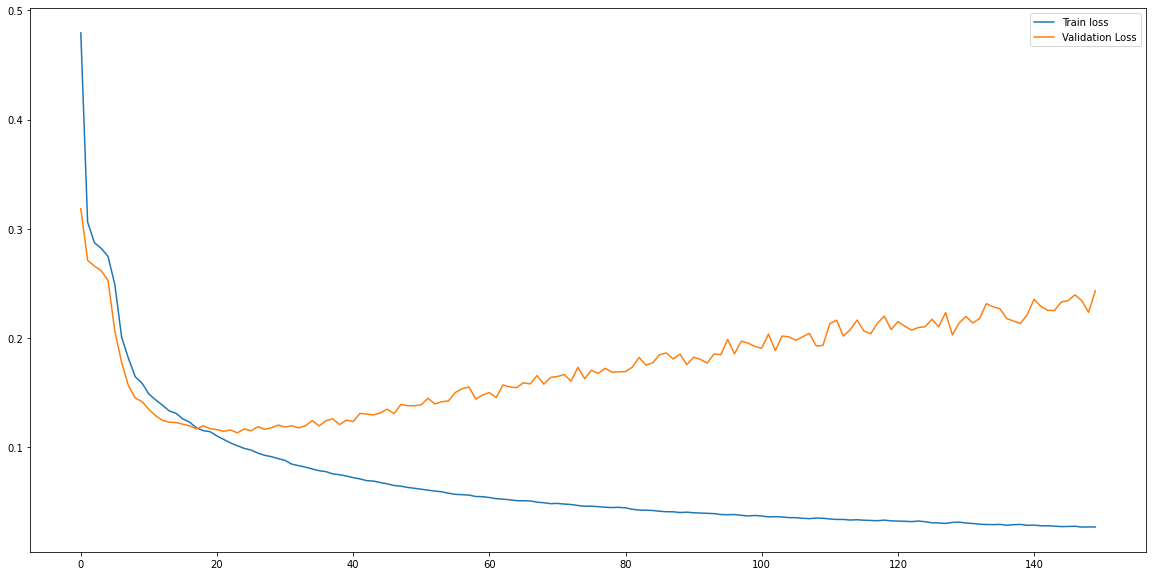

In [20]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["Train loss", "Validation Loss"])

# 7. Run predictions for test images

`/content/gdrive/My Drive/fundal_image/LadderNet/lib/extract_patches.py`

Change line 339 to 
```
new_data = np.zeros((data.shape[0],data.shape[1],int(new_img_h),(new_img_w) ))
```

Change line 307
```
full_recomp = np.empty((int(N_full_imgs), int(data.shape[1]), int(N_h*patch_h), int(N_w*patch_w) ))
```

`content/gdrive/My Drive/fundal_image/LadderNet/src/retinaNN_predict.py`

Line 159 to
```
batch_size = 64
```

In [21]:
!ls /content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE_datasets_training_testing/

DRIVE_dataset_borderMasks_test.hdf5   DRIVE_dataset_groundTruth_train.hdf5
DRIVE_dataset_borderMasks_train.hdf5  DRIVE_dataset_imgs_test.hdf5
DRIVE_dataset_groundTruth_test.hdf5   DRIVE_dataset_imgs_train.hdf5


In [22]:
root_path

'/content/gdrive/MyDrive/fundal_image/LadderNet/'

## Set configuration variables for running inference

In [23]:
# original test images (for FOV selection)
DRIVE_test_imgs_original = root_path + "DRIVE_datasets_training_testing/" +config.get('data paths', 'test_imgs_original')
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]

# the border masks provided by the DRIVE
DRIVE_test_border_masks = dataset_path + config.get('data paths', 'test_border_masks')
test_border_masks = load_hdf5(DRIVE_test_border_masks)

# the stride in case output with average
stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))
assert (stride_height < patch_height and stride_width < patch_width)

path_experiment = root_path  + name_experiment  + '/'
# N full images to be predicted
Imgs_to_test = int(config.get('testing settings', 'full_images_to_test'))
# ====== average mode ===========
average_mode = config.getboolean('testing settings', 'average_mode')

# Grouping of the predicted images for visualization
N_visual = int(config.get('testing settings', 'N_group_visual'))

## Define functions to generate test data

In [24]:
# Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))

    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h, w * patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches

# Extend the full images becasue patch divison is not exact
def paint_border(data,patch_h,patch_w):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    img_h=data.shape[2]
    img_w=data.shape[3]
    if (img_h%patch_h)==0:
        new_img_h = img_h
    else:
        new_img_h = ((int(img_h)/int(patch_h))+1)*patch_h
    if (img_w%patch_w)==0:
        new_img_w = img_w
    else:
        new_img_w = ((int(img_w)/int(patch_w))+1)*patch_w
    new_data = np.zeros((data.shape[0], data.shape[1], int(new_img_h), int(new_img_w)))
    new_data[:,:,0:img_h,0:img_w] = data[:,:,:,:]
    return new_data

# Load the original data and return the extracted patches for testing
def get_data_testing(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width):
    """
    Load the original test images and ground truth, extract patches  and return the extracted patches for testing
    :param DRIVE_test_imgs_original: 
    :param DRIVE_test_groudTruth: 
    :param Imgs_to_test: 
    :param patch_height: 
    :param patch_width: 
    :return: 
    """

    test_imgs_original = load_hdf5(DRIVE_test_imgs_original)
    gt_images = load_hdf5(DRIVE_test_groudTruth)

    test_imgs = my_PreProc(test_imgs_original)
    gt_images = gt_images / 255.

    # extend both images and masks so they can be divided exactly by the patches dimensions
    test_imgs = test_imgs[0:Imgs_to_test, :, :, :]
    gt_images = gt_images[0:Imgs_to_test, :, :, :]
    test_imgs = paint_border(test_imgs, patch_height, patch_width)
    gt_images = paint_border(gt_images, patch_height, patch_width)

    data_consistency_check(test_imgs, gt_images)

    # check masks are within 0-1
    assert (np.max(gt_images) == 1 and np.min(gt_images) == 0)

    print("\ntest images/masks shape:")
    print(test_imgs.shape)
    print("test images range (min-max): " + str(np.min(test_imgs)) + ' - ' + str(np.max(test_imgs)))
    print("test masks are within 0-1\n")

    # extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs, patch_height, patch_width)
    patches_masks_test = extract_ordered(gt_images, patch_height, patch_width)
    data_consistency_check(patches_imgs_test, patches_masks_test)

    print("\ntest PATCHES images/masks shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " + str(np.min(patches_imgs_test)) + ' - ' + str(
        np.max(patches_imgs_test)))

    return patches_imgs_test, patches_masks_test


## Load the test data and divide into patches

In [25]:
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_gt_test = None
if average_mode:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = dataset_path + config.get('data paths', 'test_groundTruth'),  
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )
else:
    patches_imgs_test, patches_gt_test = get_data_testing(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,
        DRIVE_test_groudTruth = dataset_path + config.get('data paths', 'test_groundTruth'),
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
    )


test images/masks shape:
(20, 1, 632, 613)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

number of patches per image: 156
number of patches per image: 156

test PATCHES images/masks shape:
(3120, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


## Run the prediction for the patches


In [26]:
best_last = config.get('testing settings', 'best_last')

layers= 4
filters = 10
check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers, filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'
net = LadderNetv6(num_classes=2, layers=layers, filters=filters, inplanes=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resume = True

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs):
        self.imgs = patches_imgs

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.imgs[idx,...]).float()

test_set = TrainDataset(patches_imgs_test)
test_loader = DataLoader(test_set, batch_size=batch_size,
                          shuffle=False, num_workers=4)

preds = []
for batch_idx, inputs in enumerate((test_loader)):
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = torch.nn.functional.softmax(outputs,dim=1)
    outputs = outputs.permute(0, 2, 3, 1)
    shape = list(outputs.shape)
    outputs = outputs.view(-1,shape[1]*shape[2], 2)

    outputs = outputs.data.cpu().numpy()
    preds.append(outputs)

predictions = np.concatenate(preds,axis=0)
print("Predictions finished")


==> Resuming from checkpoint..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predictions finished


## Convert the predicted arrays to corresponding image patches


In [27]:
# ===== Convert the prediction arrays in corresponding images
print(f"Shape of predictions from Laddernet  {predictions.shape}")
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")
print(f"Shape of predicted images {pred_patches.shape}")


Shape of predictions from Laddernet  (3120, 2304, 2)
Shape of predicted images (3120, 1, 48, 48)


## Tile the patches to create full image

In [28]:
def tile_patches(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    # define and start full recompone
    full_recomp = np.empty((int(N_full_imgs),data.shape[1], int(N_h*patch_h), int(N_w*patch_w)) )
    k = 0  # iter full img
    s = 0  # iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h, w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp

In [29]:
# function to set to black everything outside the FOV, in a full image
def kill_border(data, original_imgs_border_masks):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    height = data.shape[2]
    width = data.shape[3]
    for i in range(data.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==False:
                    data[i,:,y,x]=0.0

def inside_FOV_DRIVE(i, x, y, DRIVE_masks):
    assert (len(DRIVE_masks.shape)==4)  #4D arrays
    assert (DRIVE_masks.shape[1]==1)  #DRIVE masks is black and white
    # DRIVE_masks = DRIVE_masks/255.  #NOOO!! otherwise with float numbers takes forever!!

    if (x >= DRIVE_masks.shape[3] or y >= DRIVE_masks.shape[2]): #my image bigger than the original
        return False

    if (DRIVE_masks[i,0,y,x]>0):  #0==black pixels
        # print DRIVE_masks[i,0,y,x]  #verify it is working right
        return True
    else:
        return False

In [30]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = tile_patches(pred_patches,13,12)       # predictions
    orig_imgs = tile_patches(patches_imgs_test,13,12)  # originals
    gtruth_masks = tile_patches(patches_gt_test,13,12)  #gt
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))
visualize(group_images(orig_imgs,N_visual),path_experiment+"all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),path_experiment+"all_predictions")#.show()
visualize(group_images(gtruth_masks,N_visual),path_experiment+"all_groundTruths")#.show()

# visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    visualize(total_img,path_experiment+name_experiment +"_Original_GroundTruth_Prediction"+str(i))#.show()

Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)


In [31]:
# return only the pixels contained in the FOV, for both images and masks
def pred_only_FOV(data_imgs,data_masks,original_imgs_border_masks):
    assert (len(data_imgs.shape)==4 and len(data_masks.shape)==4)  #4D arrays
    assert (data_imgs.shape[0]==data_masks.shape[0])
    assert (data_imgs.shape[2]==data_masks.shape[2])
    assert (data_imgs.shape[3]==data_masks.shape[3])
    assert (data_imgs.shape[1]==1 and data_masks.shape[1]==1)  #check the channel is 1
    height = data_imgs.shape[2]
    width = data_imgs.shape[3]
    new_pred_imgs = []
    new_pred_masks = []
    for i in range(data_imgs.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==True:
                    new_pred_imgs.append(data_imgs[i,:,y,x])
                    new_pred_masks.append(data_masks[i,:,y,x])
    new_pred_imgs = np.asarray(new_pred_imgs)
    new_pred_masks = np.asarray(new_pred_masks)
    return new_pred_imgs, new_pred_masks

## Compute metrics



========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)

Area under the ROC curve: 0.9486651442057813

Area under Precision-Recall curve: 0.8322166307392783

Confusion matrix:  Costum threshold (for positive) of 0.5
[[3876633   83861]
 [ 181567  396082]]
Global Accuracy: 0.9415117593253451
Specificity: 0.9788256212482584
Sensitivity: 0.6856793658432716
Precision: 0.8252688340073717


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)



Jaccard similarity score: 0.9415117593253451

F1 score (F-measure): 0.7490260894560473


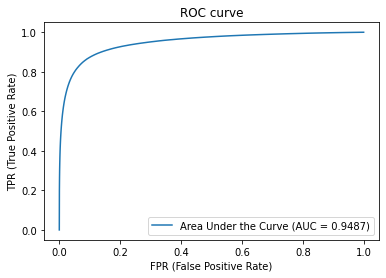

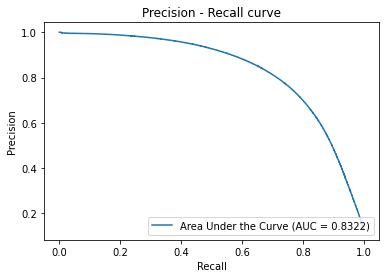

In [32]:

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

print("\n\n========  Evaluate the results =======================")
# predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)  #returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

# Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

# Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))

# F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " +str(F1_score))


## Save results

In [33]:
# Save the results
file_perf = open(path_experiment + 'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# 8. Visualize the predicted results

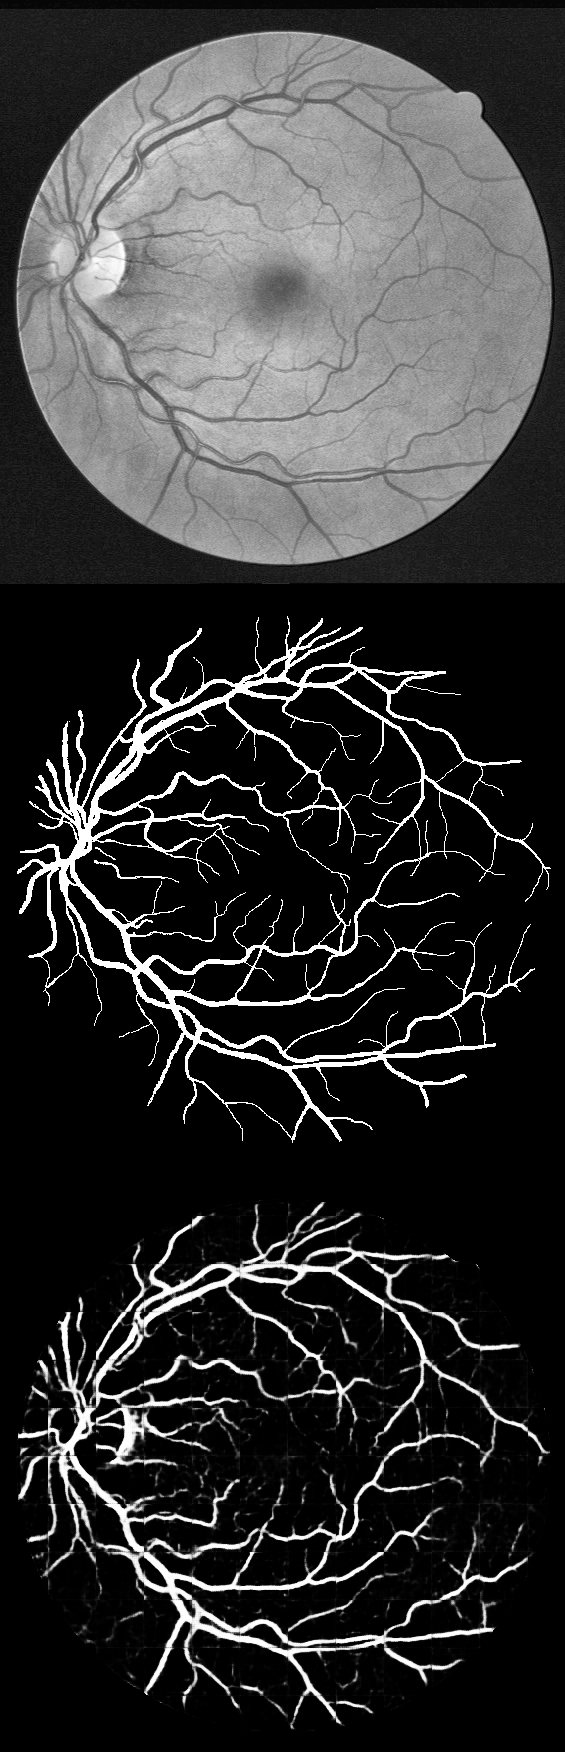

In [34]:
from IPython.display import Image
Image(root_path+'/test/test_Original_GroundTruth_Prediction0.png')